In [6]:
import os
import shutil
import tempfile
import pandas as pd
import time

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import monai
from monai.utils import set_determinism, first

from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    CenterSpatialCropd,
    EnsureChannelFirstd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,    
    RandCropByLabelClassesd,

    RandSpatialCropSamplesd,
    RandShiftIntensityd,
    RandZoomd,
    ScaleIntensityd,
    Spacingd,
    SpatialPadd,
    GaussianSmoothd,
    RandRotate90d,
    RandRotated,
    ToTensord,
    RandSpatialCropd,
    RandGaussianSmoothd,    
    RandGaussianSharpend,
    RandGaussianNoised,
)

from monai.config import print_config
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric

from monai.data import (
    DataLoader,
    Dataset,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
)

from skimage import measure
from sklearn.metrics import roc_auc_score

import torch
import glob

from monai.inferers import sliding_window_inference
print_config()

MONAI version: 1.2.0+51.g28c9083f
Numpy version: 1.24.3
Pytorch version: 2.1.1
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 28c9083f0e94934a72f9dc04d600ce2f2bd3f12b
MONAI __file__: /home/hufsaim/MONAI/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.20.0
scipy version: 1.10.1
Pillow version: 9.4.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.1
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.0
pandas version: 1.5.3
einops version: 0.6.1
transformers version: 4.29.2
mlflow version: 2.5.0
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [7]:
pwd

'/home/hufsaim/Python/2024_CapStone/240512'

In [8]:
if os.path.exists('./pretrain_log') == 0:
    os.mkdir('./pretrain_log')
    log_dir = './pretrain_log'
else:
    log_dir = './pretrain_log'

In [9]:
S = glob.glob("/mnt/breast/data_vendor/*_S_*/fgt.nii.gz")
P = glob.glob("/mnt/breast/data_vendor/*_P_*/fgt.nii.gz")
G = glob.glob("/mnt/breast/data_vendor/*_G_*/fgt.nii.gz")
print(len(S),len(P),len(G))

617 374 87


In [11]:
S_tr = S[:120]
S_ts = S[-2:]
P_tr = P[:120]
P_ts = P[-2:]
G_tr = G[:60]
G_ts = G[-2:]
print(len(S_tr),len(P_tr),len(G_tr))
print(len(S_ts),len(P_ts),len(G_ts))

120 120 60
2 2 2


In [12]:
tr_list=[]
for tmp in S_tr:
    tr_list.append(tmp.split('fgt.nii.gz')[0])

In [13]:
for tmp in P_tr:
    tr_list.append(tmp.split('fgt.nii.gz')[0])

In [14]:
for tmp in G_tr:
    tr_list.append(tmp.split('fgt.nii.gz')[0])

In [15]:
ts_list=[]
for tmp in S_ts:
    ts_list.append(tmp.split('fgt.nii.gz')[0])

In [16]:
for tmp in P_ts:
    ts_list.append(tmp.split('fgt.nii.gz')[0])

In [17]:
for tmp in G_ts:
    ts_list.append(tmp.split('fgt.nii.gz')[0])

In [18]:
train_ind = np.arange(0,len(tr_list))
data_dicts = [
    {
        "image1": os.path.join(tr_list[idx] ,"t1_pre.nii.gz"),
        "seg": os.path.join(tr_list[idx],"fgt.nii.gz"),            
    }
    for idx in train_ind
]
train_Data =  data_dicts

In [19]:
val_ind = np.arange(0,len(ts_list))

data_dicts = [
    {
        "image1": os.path.join(ts_list[idx] ,"t1_pre.nii.gz"),
        "seg": os.path.join(ts_list[idx],"fgt.nii.gz"),              
    }
    for idx in val_ind
]

val_Data =  data_dicts

In [20]:
print(len(train_Data),len(val_Data))

300 6


In [21]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image1","seg"]),
        EnsureChannelFirstd(keys=["image1","seg"]),
        
        ScaleIntensityd(
                keys=["image1"],
                minv=0.0,
                maxv=1.0,
        ),    
        
        RandShiftIntensityd(
            keys=["image1"],
            offsets=0.05,
            prob=0.5,
        ),       
        
        RandZoomd(
            keys=["image1", "seg"],
            prob = 0.75,
            min_zoom = 0.5,
            max_zoom = 2.0,
            mode = ['area','nearest']
        ),

        RandGaussianNoised(keys=["image1"],
                           prob=0.5, mean=0.0, std=0.01, 
                           allow_missing_keys=False),
        RandGaussianSmoothd(keys=["image1"],
                            sigma_x=(0.25, 1.5), sigma_y=(0.25, 1.5), sigma_z=(0.25, 1.5)
                            , approx='erf', prob=0.5, allow_missing_keys=False),
        RandGaussianSharpend(keys=["image1"],
                             sigma1_x=(0.5, 1.0), sigma1_y=(0.5, 1.0), sigma1_z=(0.5, 1.0), 
                             sigma2_x=0.5, sigma2_y=0.5, sigma2_z=0.5, alpha=(10.0, 30.0)
                             , approx='erf', prob=0.5, allow_missing_keys=False),

        SpatialPadd(keys=["image1","seg"], spatial_size=(192,192, 64)),
        RandCropByPosNegLabeld(
            keys=["image1","seg"],
            label_key="seg",
            spatial_size=(160, 160, 48),
            pos=2,
            neg=1,
            num_samples=3,
        ),
        
        RandRotated(keys=["image1","seg"],
            mode=["bilinear","nearest"],
            range_x=0.75, range_y=0.0, range_z=0.0,
            prob=0.75),
        
        CenterSpatialCropd(keys=["image1","seg"],
                         roi_size=(96,96,32)),

        RandFlipd(
            keys=["image1", "seg"],
            spatial_axis=[0],
            prob=0.5,
        ),
        RandFlipd(
            keys=["image1","seg"],
            spatial_axis=[1],
            prob=0.5,
        ),
        RandFlipd(
            keys=["image1", "seg"],
            spatial_axis=[2],
            prob=0.5,
        ),
        RandRotate90d(
            keys=["image1", "seg"],
            prob=0.25,
            max_k=3,
        ),
        ToTensord(keys=["image1","seg"]),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image1","seg"]),
        EnsureChannelFirstd(keys=["image1","seg"]),         
        ScaleIntensityd(
                keys=["image1"],
                minv=0.0,
                maxv=1.0,
        ),         
        ToTensord(keys=["image1","seg"]),
    ]
)

monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.


In [22]:
check_ds = Dataset(data=train_Data, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)

image shape: torch.Size([96, 96, 32])


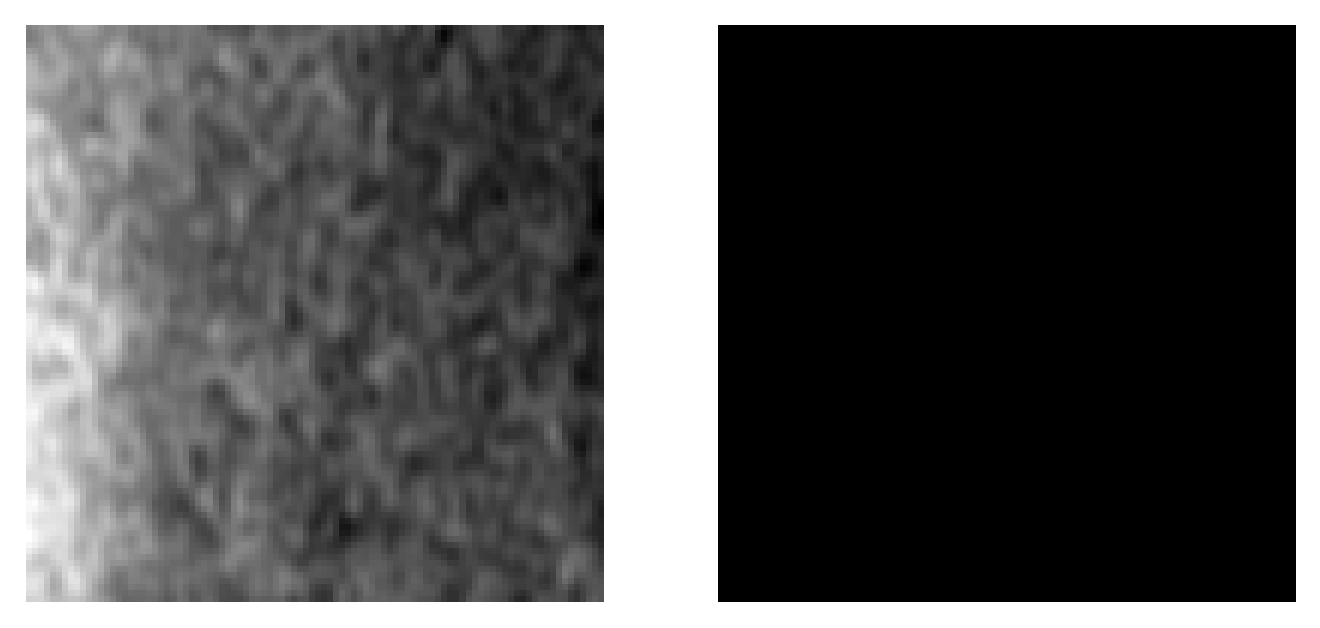

metatensor(0.)
image shape: torch.Size([96, 96, 32])


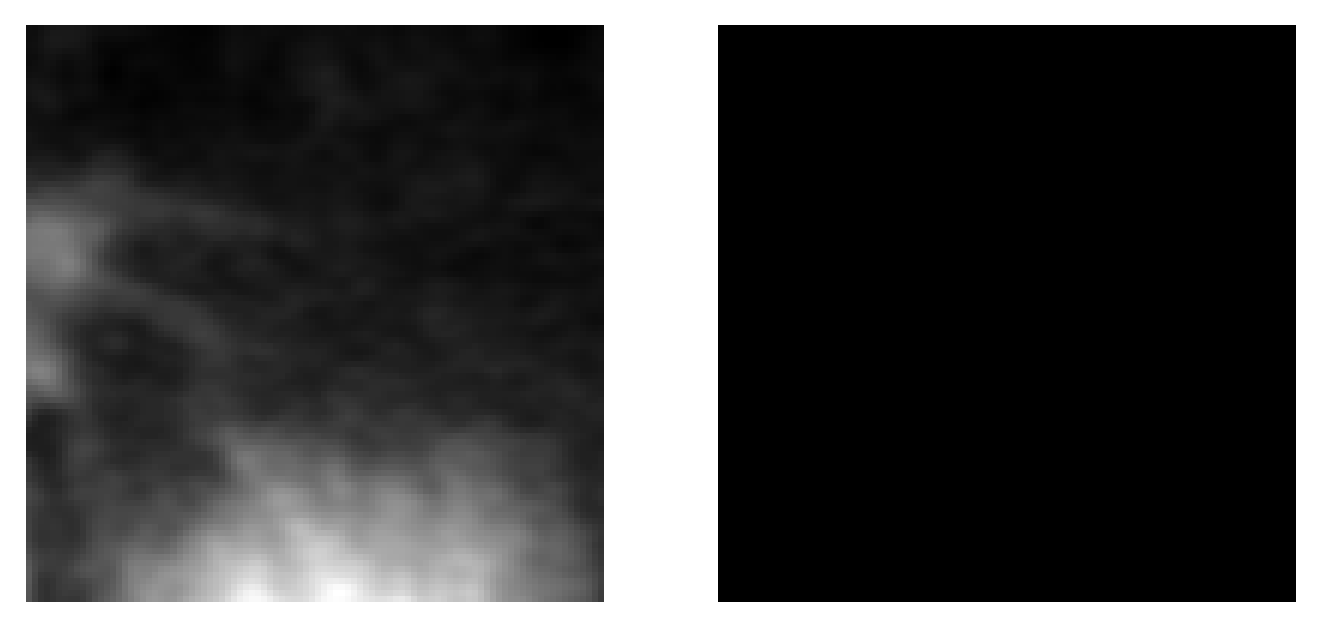

metatensor(0.)
image shape: torch.Size([96, 96, 32])


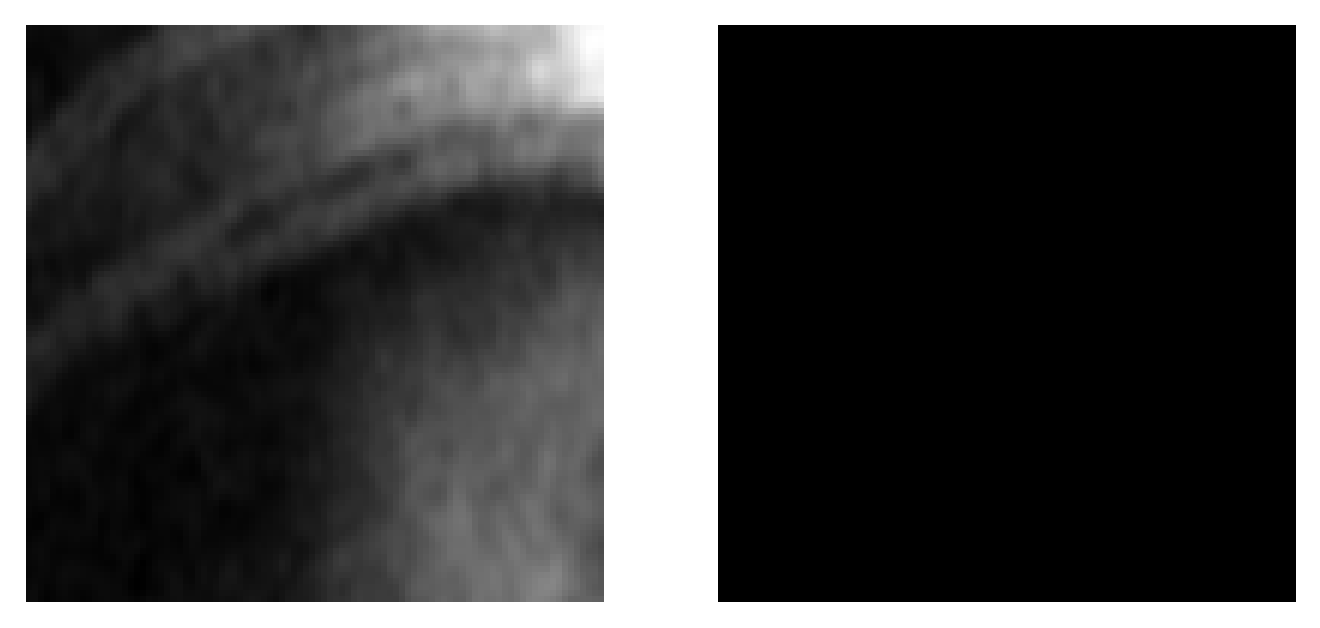

metatensor(0.)


In [23]:
for N in range(len(check_data["image1"])):
    pre = (check_data["image1"][N][0])
    seg = (check_data["seg"][N][0])

    print(f"image shape: {pre.shape}")
    plt.figure(dpi=256)
    plt.subplot(121)
    plt.imshow(torch.sum(pre,axis=2),cmap='gray')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(torch.sum(seg,axis=2),cmap='gray')
    plt.axis('off')
    plt.show()
    print(torch.max(seg))

In [24]:
train_ds = Dataset(
    data=train_Data,
    transform=train_transforms,
)

In [25]:
val_ds = Dataset(
    data=val_Data,
    transform=val_transforms,
)

In [26]:
train_loader = DataLoader(
    train_ds, batch_size=1, shuffle=True,
)
valid_loader = DataLoader(
    val_ds, batch_size=1, shuffle=True, 
)

In [27]:
device= "cuda:0"
model = monai.networks.nets.SwinUNETR(img_size=(96,96,32), in_channels=1, out_channels=3, feature_size=48).to(device)

In [28]:
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
torch.backends.cudnn.benchmark = True

In [29]:
def validation(epoch_iterator_val):
    model.eval()
    dice_vals = list()
    with torch.no_grad():
        for step, batch in enumerate(epoch_iterator_val):
            val_inputs, val_labels = (batch["image1"]).to(device), batch["seg"].to(device)
            val_outputs = sliding_window_inference(val_inputs, (96, 96, 32), 4, model)

#             val_labels[val_labels > 0] = 1
            if step==0:
                plt.figure(dpi=256)
                plt.subplot(141)
                plt.imshow(torch.sum(val_inputs[0,0].cpu(),axis=2),cmap='gray')
                plt.axis('off')
                plt.title('input')
                plt.subplot(142)
                plt.imshow(torch.sum(val_outputs[0,1].detach().cpu(),axis=2),cmap='gray')
                plt.axis('off')
                plt.title('output1')
                plt.subplot(143)
                plt.imshow(torch.sum(val_outputs[0,2].detach().cpu(),axis=2),cmap='gray')
                plt.axis('off')
                plt.title('output2')
                plt.subplot(144)
                plt.imshow(torch.sum(val_labels[0,0].detach().cpu(),axis=2),cmap='gray')
                plt.axis('off')
                plt.title('label')
                plt.show()            
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [
                post_label(val_label_tensor) for val_label_tensor in val_labels_list
            ]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [
                post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list
            ]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            dice = dice_metric.aggregate().item()
            dice_vals.append(dice)
            epoch_iterator_val.set_description(
                "Validate (%d / %d Steps) (dice=%2.5f)" % (global_step, 10.0, dice)
            )
                  
        dice_metric.reset()
    mean_dice_val = np.mean(dice_vals)
    return mean_dice_val

In [30]:
def train(global_step, train_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(
        train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True
    )
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image1"]).to(device), batch["seg"].to(device)
        #y[y>0] = 1
        
        logit_map = model(x)
        
        loss = loss_function(logit_map, y)
        loss.backward()
        epoch_loss += loss.item()
        
        optimizer.step()
        optimizer.zero_grad()
        epoch_iterator.set_description(
            "Training (%d / %d Steps) (loss=%2.5f)" % (global_step, max_iterations, loss)
        )
        if (
            global_step % eval_num == 0 and global_step != 0
        ) or global_step == max_iterations:
            epoch_iterator_val = tqdm(
                valid_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True
            )
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            plt.plot(epoch_loss_values)
            plt.savefig(os.path.join(log_dir,'loss.png'))
            plt.close()
            metric_values.append(dice_val)
            plt.plot(metric_values)
            plt.savefig(os.path.join(log_dir,'dice.png'))
            plt.close()
            
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                
                f = open(os.path.join(log_dir,'log.txt'),'a')
                f.write(f'dice_val_best : {dice_val_best}')
                f.write('\n')
                f.write(f'global_step_best : {global_step_best}')
                f.write('\n\n')
                f.close()
                
                
                
                torch.save(
                    model.state_dict(), os.path.join( log_dir, f"seg_model_best_vxxxx.pth")
                )
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1

#    scheduler.step()

    return global_step, dice_val_best, global_step_best

In [31]:
max_iterations = 210000
eval_num = 200
post_label = AsDiscrete(to_onehot=3)
post_pred = AsDiscrete(argmax=True, to_onehot=3)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []

In [32]:
pwd

'/home/hufsaim/Python/2024_CapStone/240512'

In [33]:
# model.load_state_dict(torch.load("./base700_log/seg_model_best_vxxxx.pth"))

Training (X / X Steps) (loss=X.X):   0%|                | 0/300 [00:00<?, ?it/s]Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1699449183005/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
Training (200 / 210000 Steps) (loss=1.52896):  67%|▋| 200/300 [29:00<14:33,  8.7
Validate (X / X Steps) (dice=X.X):   0%|                  | 0/6 [00:00<?, ?it/s]

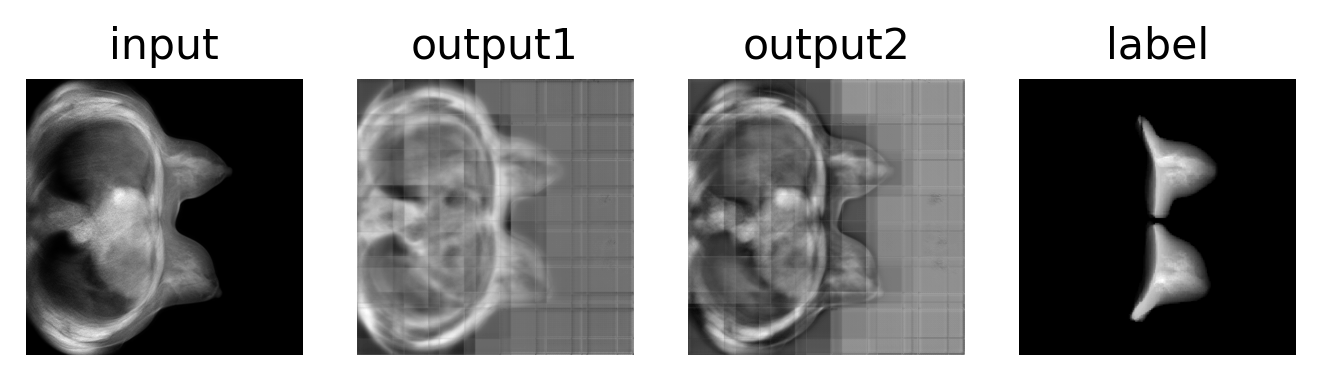


Validate (0 / 10 Steps) (dice=0.43208): 100%|█████| 6/6 [02:18<00:00, 23.08s/it]
Training (200 / 210000 Steps) (loss=1.52896):  67%|▋| 201/300 [31:18<1:23:34, 50

Model Was Saved ! Current Best Avg. Dice: 0.435488020380338 Current Avg. Dice: 0.435488020380338


Training (299 / 210000 Steps) (loss=1.32200): 100%|█| 300/300 [46:16<00:00,  9.2
Training (400 / 210000 Steps) (loss=1.38195):  33%|▎| 100/300 [10:35<23:30,  7.0
Validate (X / X Steps) (dice=X.X):   0%|                  | 0/6 [00:00<?, ?it/s]

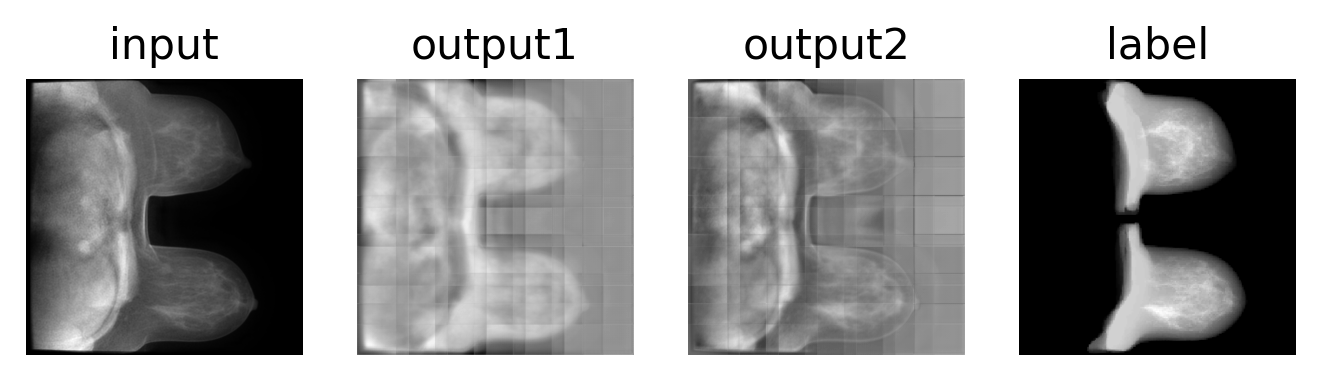


Validate (300 / 10 Steps) (dice=0.47279): 100%|███| 6/6 [01:59<00:00, 19.85s/it]
Training (400 / 210000 Steps) (loss=1.38195):  34%|▎| 101/300 [12:34<2:22:11, 42

Model Was Saved ! Current Best Avg. Dice: 0.47900443772474927 Current Avg. Dice: 0.47900443772474927


Training (599 / 210000 Steps) (loss=1.02136): 100%|█| 300/300 [31:14<00:00,  6.2
Validate (X / X Steps) (dice=X.X):   0%|                  | 0/6 [00:00<?, ?it/s]

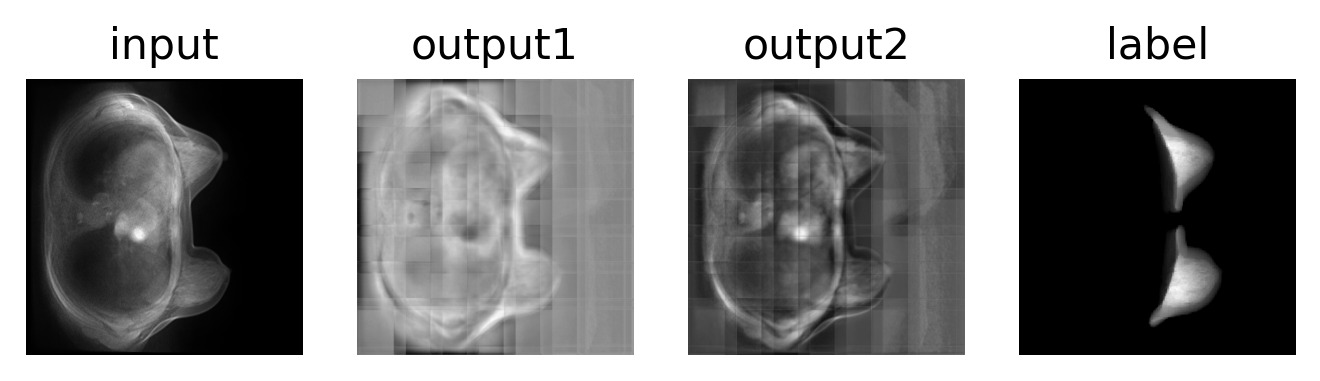


Validate (600 / 10 Steps) (dice=0.50483): 100%|███| 6/6 [01:54<00:00, 19.17s/it]
Training (600 / 210000 Steps) (loss=1.19444):   0%| | 1/300 [02:00<9:59:35, 120.

Model Was Saved ! Current Best Avg. Dice: 0.5084000378847122 Current Avg. Dice: 0.5084000378847122


Training (800 / 210000 Steps) (loss=1.33009):  67%|▋| 200/300 [21:21<06:16,  3.7
Validate (X / X Steps) (dice=X.X):   0%|                  | 0/6 [00:00<?, ?it/s]

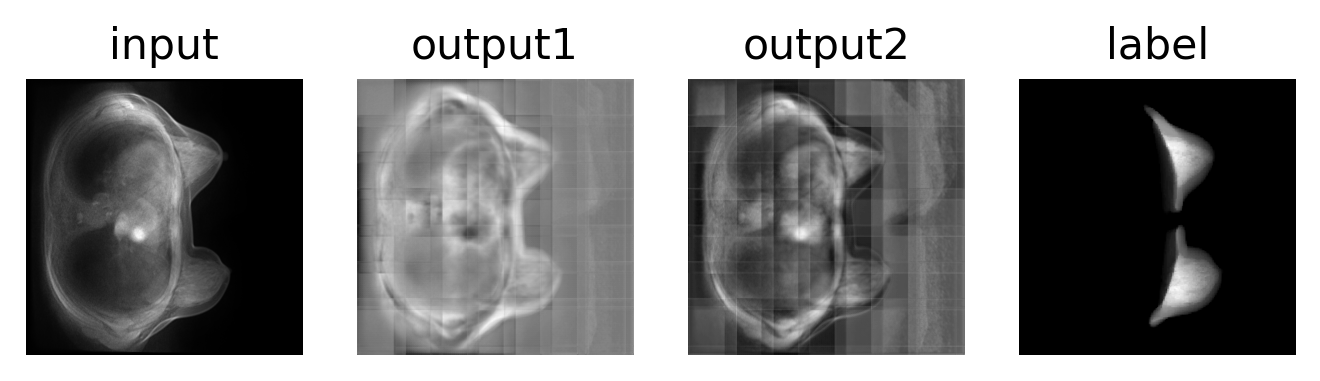


Validate (600 / 10 Steps) (dice=0.52380): 100%|███| 6/6 [02:24<00:00, 24.02s/it]
Training (800 / 210000 Steps) (loss=1.33009):  67%|▋| 201/300 [23:45<1:18:20, 47

Model Was Saved ! Current Best Avg. Dice: 0.5147934605677923 Current Avg. Dice: 0.5147934605677923


Training (899 / 210000 Steps) (loss=1.23658): 100%|█| 300/300 [32:43<00:00,  6.5
Training (1000 / 210000 Steps) (loss=1.62916):  33%|▎| 100/300 [10:18<19:35,  5.
Validate (X / X Steps) (dice=X.X):   0%|                  | 0/6 [00:00<?, ?it/s]

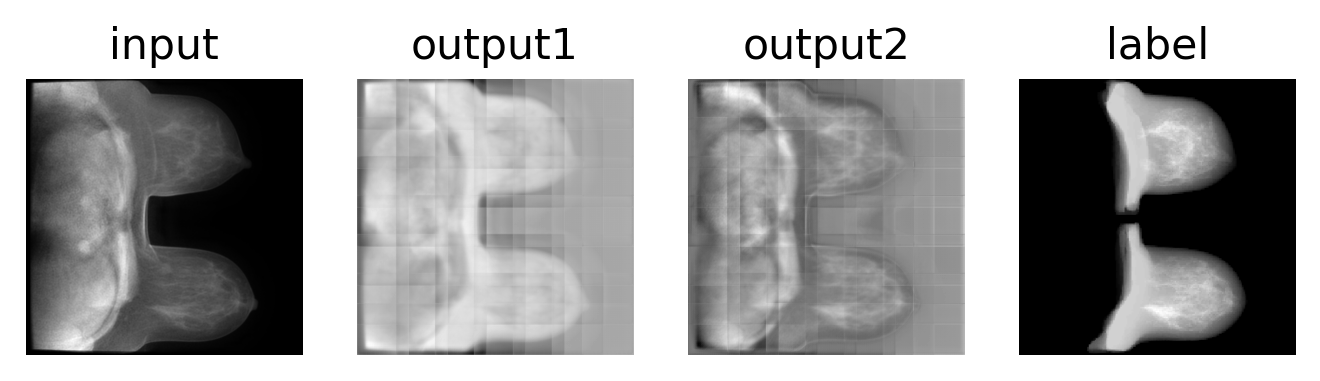


Validate (900 / 10 Steps) (dice=0.53029): 100%|███| 6/6 [02:18<00:00, 23.13s/it]
Training (1000 / 210000 Steps) (loss=1.62916):  34%|▎| 101/300 [12:37<2:39:25, 4

Model Was Saved ! Current Best Avg. Dice: 0.5476038257280985 Current Avg. Dice: 0.5476038257280985


Training (1199 / 210000 Steps) (loss=0.98146): 100%|█| 300/300 [33:56<00:00,  6.
Validate (X / X Steps) (dice=X.X):   0%|                  | 0/6 [00:00<?, ?it/s]

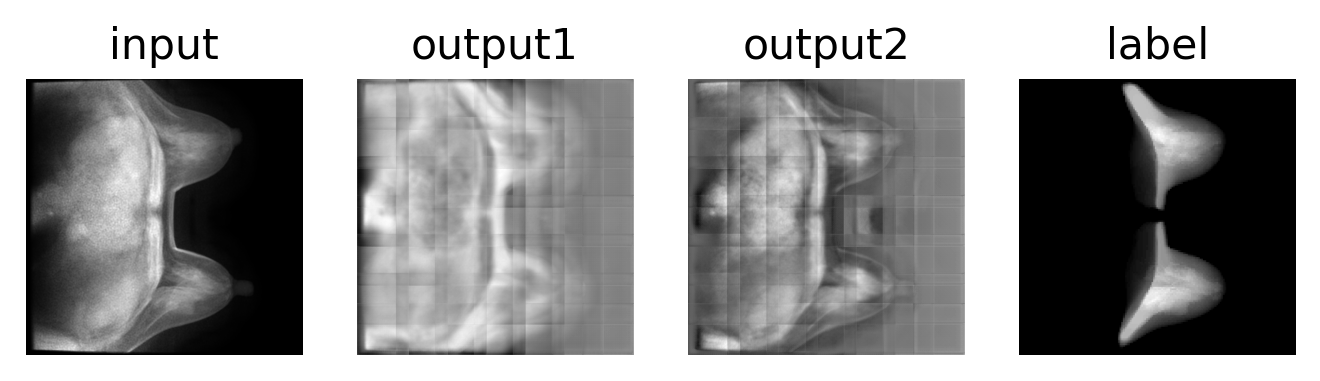


Validate (1200 / 10 Steps) (dice=0.49622): 100%|██| 6/6 [01:59<00:00, 19.93s/it]
Training (1200 / 210000 Steps) (loss=1.05993):   0%| | 1/300 [02:05<10:26:20, 12

Model Was Not Saved ! Current Best Avg. Dice: 0.5476038257280985 Current Avg. Dice: 0.4814187288284302


Training (1286 / 210000 Steps) (loss=1.38396):  29%|▎| 87/300 [10:41<24:28,  6.8

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=.42e-4)

while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(
        global_step, train_loader, dice_val_best, global_step_best
    )

In [ ]:
torch.save(
                    model.state_dict(), os.path.join( log_dir, f"pretrain.pth")
                )

In [31]:
global_step

19650

In [ ]:
# optimizer = torch.optim.AdamW(model.parameters(), lr=.14e-4)

# while global_step < 3*max_iterations:
#     global_step, dice_val_best, global_step_best = train(
#         global_step, train_loader, dice_val_best, global_step_best
#     )

In [ ]:
# torch.save(
#                     model.state_dict(), os.path.join( log_dir, f"seg_model_last13000_v240411.pth")
#                 )

In [32]:
global_step_best

17200

NameError: name 'global_step' is not defined